## Prepared BY:
- Mirette Amin   20190570
- Nader Atef     20190575

In [ ]:
import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
import gc
import matplotlib.pyplot as plt
import cv2
import glob
import warnings
warnings.filterwarnings("ignore")
import os
from google.colab.patches import cv2_imshow

In [ ]:
!wget 'http://chaladze.com/l5/img/Linnaeus 5 128X128.rar' \ -O dataset.rar
!pip install unrar
!unrar x '/content/Linnaeus 5 128X128.rar'

In [ ]:
# !pip install unrar
# !unrar x '/content/Linnaeus 5 128X128.rar'

In [ ]:
len(glob.glob("/content/Linnaeus 5 128X128/test/dog/*.jpg"))

400

In [ ]:
train = glob.glob("/content/Linnaeus 5 64X64/train/dog/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/flower/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/bird/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/berry/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/other/*.jpg")[:1200] # 1200

train += glob.glob("/content/Linnaeus 5 64X64/test/dog/*.jpg")[:200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/flower/*.jpg")[:200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/bird/*.jpg")[:200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/berry/*.jpg")[:200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/other/*.jpg")[:200] # 1200

test= glob.glob("/content/Linnaeus 5 64X64/test/dog/*.jpg")[200:300] # 1200
test += glob.glob("/content/Linnaeus 5 64X64/test/other/*.jpg")[200:300] # 1200
# train = train + glob.glob("/content/Linnaeus 5 64X64/test/flower/*.jpg")[:100] # 1200
# train = train + glob.glob("/content/Linnaeus 5 64X64/test/bird/*.jpg")[:100] # 1200


# Shuffle Data
import random

random.shuffle(train)
random.shuffle(test)

In [ ]:
train_tensor = []
for image in train:
  img = cv2.imread(image)
  train_tensor.append(img)
train = np.array(train_tensor)/255.0
train = np.float32(train)
test_tensor = []
for image in test:
  img = cv2.imread(image)
  test_tensor.append(img)
test = np.array(test_tensor)/255.0
test = np.float32(test)
  

In [ ]:
# Add noise to input data
noise = np.random.normal(0, 0.1, size=(len(train), 64, 64, 3))

noisy_train = (train + noise)
noisy_test = (test + np.random.normal(0, 0.1, size=(len(test), 64, 64, 3)))
noisy_train = np.float32(noisy_train)
noisy_test = np.float32(noisy_test)
del noise
gc.collect()

0

In [ ]:
# dog_img = cv2.imread("/content/beautiful-happy-reddish-havanese-puppy-dog-sitting-frontal-looking-camera-isolated-white-background-46868560.jpg")/255.0
# dog_img = cv2.resize(dog_img, (128, 128))
# noisy_dog_img = dog_img + np.random.normal(0, 0.1, size=(dog_img.shape[0], dog_img.shape[1], 3))

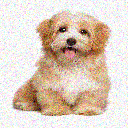

In [ ]:
# cv2_imshow(noisy_dog_img*255)

In [ ]:
import tensorflow as tf
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
from keras.layers.convolutional.conv1d import activations
def create_autoencoder(vec_size):

  input = keras.Input(shape=(64, 64, 3))

  # 128x128x3
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input) # 128x128x16
  x = layers.MaxPooling2D((2, 2), padding='same')(x) # 64x64x16
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x) # 64x64x32
  x = layers.MaxPooling2D((2, 2), padding='same')(x) # 32x32x32
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 32x32x64
  x = layers.MaxPooling2D((2, 2), padding='same')(x) # 16x16x32
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 16x16x1 = 256
  # x = layers.MaxPooling2D((2, 2), padding='same')(x) # 16x16x32
  # x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x) # 16x16x1 = 256
  # pool = 256/vec_size
  # x = layers.MaxPooling2D((pool, pool), padding='same')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(vec_size, activation = "linear")(x)

  encoder = keras.Model(input, x)
  encoded = x
  input_vec = keras.Input(shape=(vec_size,))

  x = layers.Dense(8 * 8 * 128, activation = "linear")(encoded)

  x = layers.Reshape((8, 8, 128))(x)
  # at this point the representation is (vec_size, 1)

  # stride * (in_size-1) + kernel_size - 2*padding

  # x = layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  decoded = layers.Conv2D(3, (3, 3), padding='same')(x)
  autoencoder = keras.Model(input, decoded)
  dec  = autoencoder.layers[-6](input_vec)
  for i in range(5, 0, -1):
    dec = autoencoder.layers[-i](dec)
  
  decoder = keras.Model(input_vec, dec)
  autoencoder.compile("adam", loss='mean_squared_error')

  return autoencoder, encoder, decoder
def plt_img(img):
  plt.axis("off")
  plt.imshow(cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
autoencoder1, enc1, dec1 = create_autoencoder(8)

In [ ]:
autoencoder1.fit(noisy_train, train,
                epochs=70,
                batch_size=64,
                shuffle=True,
                validation_data=(noisy_test, test),)


219/219 [==============================] - 1s 4ms/step


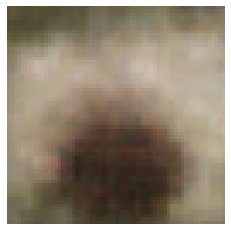

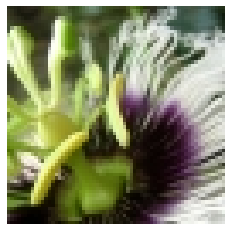

In [ ]:
decoded_imgs_t = autoencoder1.predict(noisy_train)
plt_img(decoded_imgs_t[88])
plt_img(train[88])

In [ ]:
autoencoder2, enc2, dec2 = create_autoencoder(16)
autoencoder2.fit(noisy_train, train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(noisy_test, test))


219/219 [==============================] - 1s 3ms/step


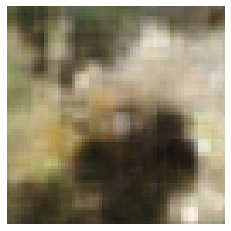

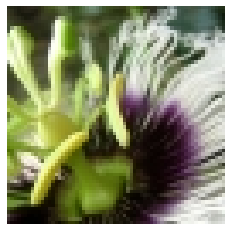

In [ ]:
decoded_imgs_t = autoencoder2.predict(noisy_train)
plt_img(decoded_imgs_t[88])
plt_img(train[88])

In [ ]:
# autoencoder8, enc8, dec8 = create_autoencoder(8)
# autoencoder8.summary()

In [ ]:
# autoencoder16, enc16, dec16 = create_autoencoder(16)
# autoencoder16.summary()

In [ ]:
autoencoder32, enc32, dec32 = create_autoencoder(32)
autoencoder32.summary()
autoencoder32.fit(noisy_train, train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(noisy_test, test))



219/219 [==============================] - 1s 3ms/step


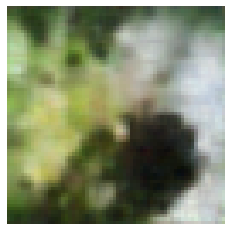

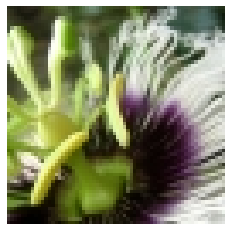

In [ ]:
decoded_imgs_t = autoencoder32.predict(noisy_train)
plt_img(decoded_imgs_t[88])
plt_img(train[88])

In [ ]:
autoencoder64, enc64, dec64 = create_autoencoder(64)
# autoencoder64.summary()
autoencoder64.fit(noisy_train, train,
                epochs=100,
                batch_size=64,
                
                shuffle=True,
                validation_data=(noisy_test, test))



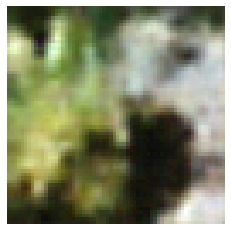

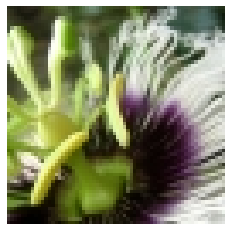

In [ ]:
decoded_imgs_t = autoencoder64.predict(noisy_train)
plt_img(decoded_imgs_t[88])
plt_img(train[88])

In [ ]:
autoencoder256, enc256, dec256 = create_autoencoder(256)
# autoencoder256.summary()
autoencoder256.fit(noisy_train, train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(noisy_test, test))

Epoch 1/100
110/110 [==============================] - 2s 17ms/step - loss: 0.0885 - val_loss: 0.0379
Epoch 2/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0362 - val_loss: 0.0288
Epoch 3/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0302 - val_loss: 0.0264
Epoch 4/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0273 - val_loss: 0.0223
Epoch 5/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0248 - val_loss: 0.0184
Epoch 6/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0205 - val_loss: 0.0162
Epoch 7/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0182 - val_loss: 0.0155
Epoch 8/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0172 - val_loss: 0.0186
Epoch 9/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0164 - val_loss: 0.0136
Epoch 10/100
110/110 [==============================] - 2s 14ms/step - loss: 0.014

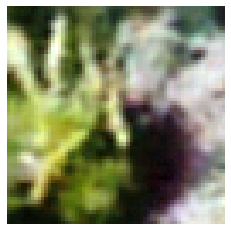

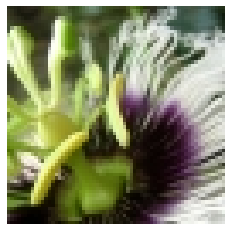

In [ ]:
decoded_imgs_t = autoencoder256.predict(noisy_train)
plt_img(decoded_imgs_t[88])
plt_img(train[88])

1/1 [==============================] - 0s 16ms/step


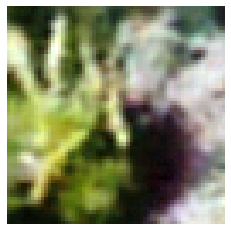

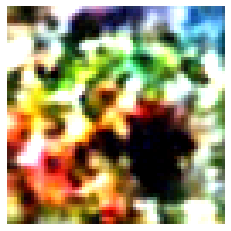

In [ ]:
normal_output = autoencoder256.predict(noisy_train[88:91])
vec= enc256.predict(train[88:91])
vec += np.random.normal(0, 1, (3, 256))
decoded_from_noise = dec256.predict(vec)
plt_img(normal_output[0])
plt_img(decoded_from_noise[0])

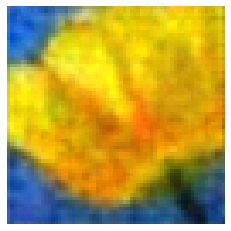

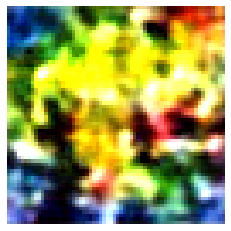

In [ ]:
plt_img(normal_output[1])
plt_img(decoded_from_noise[1])

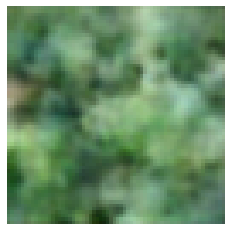

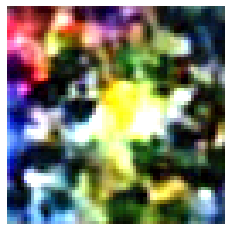

In [ ]:
plt_img(normal_output[2])
plt_img(decoded_from_noise[2])

In [ ]:
from sklearn.decomposition import PCA

pca8 = PCA(8)
pca16 = PCA(16)
pca32 = PCA(32)
pca64 = PCA(64)

imgs = pca8.fit_transform(train.reshape(len(train), -1))

restored_imgs  = pca32.inverse_transform(img)
plt_img(restored_imgs[0].reshape(train[6].shape))

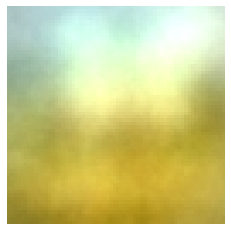

In [ ]:
restored_img  = pca32.inverse_transform(imgs)
plt_img(restored_img[0].reshape(train[0].shape))

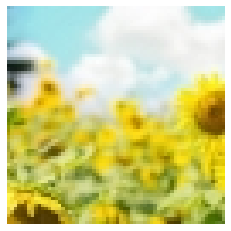

In [ ]:
plt_img(train[0])